In [86]:
#import library
import os
from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [87]:
#config
DATASET_ROOT = Path("dataset")
IMG_SIZE = 32                    # normalized char image size
ZONES = (2, 2)                   # zoning grid
K = 3                            # kNN
TRAIN_SPLIT = 0.8
SEED = 42

LABELS = [chr(ord('A') + i) for i in range(26)]
EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

In [88]:
def preprocess_char(img_bgr: np.ndarray, out_size: int = 32) -> np.ndarray:
    """
    Output: binary image (out_size x out_size), foreground ink = 255.
    """
    if img_bgr is None:
        raise ValueError("Image is None")

    # 1) grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2) denoise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # 3) binarize (Otsu) and invert => ink becomes white
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 4) remove small noise
    kernel = np.ones((2, 2), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations=1)

    # 5) crop to foreground
    coords = cv2.findNonZero(bw)
    if coords is None:
        return np.zeros((out_size, out_size), dtype=np.uint8)

    x, y, w, h = cv2.boundingRect(coords)
    cropped = bw[y:y+h, x:x+w]

    # 6) pad to square
    h2, w2 = cropped.shape
    side = max(h2, w2)
    square = np.zeros((side, side), dtype=np.uint8)
    y0 = (side - h2) // 2
    x0 = (side - w2) // 2
    square[y0:y0+h2, x0:x0+w2] = cropped

    # 7) resize
    resized = cv2.resize(square, (out_size, out_size), interpolation=cv2.INTER_AREA)

    return resized

In [89]:
def zoning_features(bin_img: np.ndarray, zones=(4, 4)) -> np.ndarray:
    """
    Split into zones grid and compute normalized foreground density per cell.
    """
    h, w = bin_img.shape
    zy, zx = zones
    cell_h = h // zy
    cell_w = w // zx

    feats = []
    total_pixels = cell_h * cell_w

    for iy in range(zy):
        for ix in range(zx):
            cell = bin_img[iy*cell_h:(iy+1)*cell_h, ix*cell_w:(ix+1)*cell_w]
            fg = np.count_nonzero(cell)  # foreground pixels (255)
            feats.append(fg / total_pixels)

    return np.array(feats, dtype=np.float32)


def global_shape_features(bin_img: np.ndarray) -> np.ndarray:
    """
    Global features:
    - ink density
    - bounding box aspect ratio
    """
    density = np.count_nonzero(bin_img) / bin_img.size

    coords = cv2.findNonZero(bin_img)
    if coords is None:
        aspect = 1.0
    else:
        x, y, w, h = cv2.boundingRect(coords)
        aspect = (w / h) if h > 0 else 1.0

    return np.array([density, aspect], dtype=np.float32)


def extract_features(bin_img: np.ndarray) -> np.ndarray:
    z = zoning_features(bin_img, zones=ZONES)
    g = global_shape_features(bin_img)
    return np.concatenate([z, g], axis=0)

In [90]:
def load_dataset(root: Path):
    X, y, paths = [], [], []

    if not root.exists():
        raise FileNotFoundError(f"Dataset root not found: {root.resolve()}")

    for writer_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        for letter in LABELS:
            letter_dir = writer_dir / letter
            if not letter_dir.exists():
                continue

            for img_path in sorted(letter_dir.iterdir()):
                if img_path.suffix.lower() not in EXTS:
                    continue

                img = cv2.imread(str(img_path))
                if img is None:
                    continue

                bin_img = preprocess_char(img, out_size=IMG_SIZE)
                feat = extract_features(bin_img)

                X.append(feat)
                y.append(ord(letter) - ord('A'))
                paths.append(str(img_path))

    if len(X) == 0:
        raise RuntimeError("No images found. Check folder structure and file extensions.")

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    return X, y, paths

X, y, paths = load_dataset(DATASET_ROOT)

print("Loaded samples:", len(y))
print("Feature length:", X.shape[1], f"(zoning={ZONES[0]*ZONES[1]} + 2 global)")

Loaded samples: 186
Feature length: 6 (zoning=4 + 2 global)


Sample: dataset/writer1/G/G_008.png


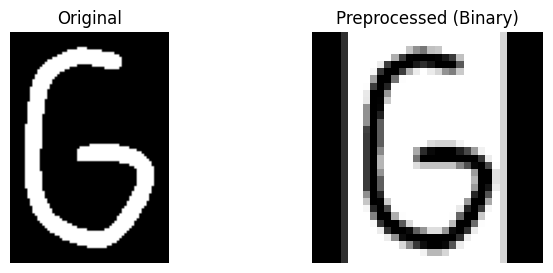

Sample: dataset/writer1/A/A_017.png


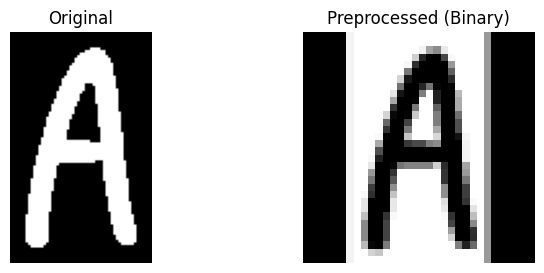

Sample: dataset/writer1/H/H_013.png


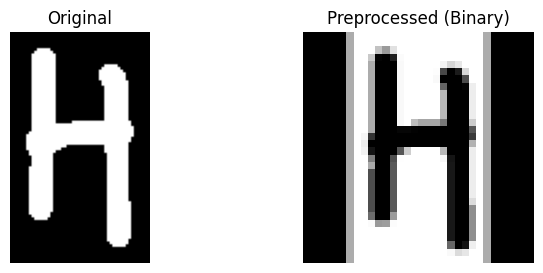

In [91]:
def show_preprocess_example(img_path: str):
    img = cv2.imread(img_path)
    bin_img = preprocess_char(img, out_size=IMG_SIZE)

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed (Binary)")
    plt.imshow(bin_img, cmap="gray")
    plt.axis("off")
    plt.show()

# show 3 random samples
rng = np.random.default_rng(SEED)
for idx in rng.choice(len(paths), size=min(3, len(paths)), replace=False):
    print("Sample:", paths[idx])
    show_preprocess_example(paths[idx])


In [92]:
def train_test_split_stratified(X, y, train_ratio=0.8, seed=42):
    rng = np.random.default_rng(seed)
    idx_by_class = defaultdict(list)
    for i, label in enumerate(y):
        idx_by_class[int(label)].append(i)

    train_idx, test_idx = [], []
    for c in range(26):
        idxs = idx_by_class.get(c, [])
        if len(idxs) == 0:
            continue
        idxs = np.array(idxs)
        rng.shuffle(idxs)

        cut = int(len(idxs) * train_ratio)
        train_idx.extend(idxs[:cut].tolist())
        test_idx.extend(idxs[cut:].tolist())

    train_idx = np.array(train_idx, dtype=np.int32)
    test_idx  = np.array(test_idx, dtype=np.int32)

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx], train_idx, test_idx

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split_stratified(
    X, y, train_ratio=TRAIN_SPLIT, seed=SEED
)

print("Train:", len(y_train), "Test:", len(y_test))

Train: 146 Test: 40


In [93]:
def knn_predict(X_train, y_train, X_test, k=3):
    preds = []
    for x in X_test:
        dists = np.linalg.norm(X_train - x, axis=1)
        nn_idx = np.argsort(dists)[:k]
        nn_labels = y_train[nn_idx]
        counts = np.bincount(nn_labels, minlength=26)
        preds.append(int(np.argmax(counts)))
    return np.array(preds, dtype=np.int32)

y_pred = knn_predict(X_train, y_train, X_test, k=K)


In [94]:
def accuracy(y_true, y_pred):
    return float(np.mean(y_true == y_pred))

def confusion_matrix(y_true, y_pred, num_classes=26):
    cm = np.zeros((num_classes, num_classes), dtype=np.int32)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

acc = accuracy(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, num_classes=26)

print(f"k-NN (k={K}) Accuracy: {acc*100:.2f}%")

# Show top confusions
pairs = []
for i in range(26):
    for j in range(26):
        if i != j and cm[i, j] > 0:
            pairs.append((cm[i, j], i, j))
pairs.sort(reverse=True)

print("\nTop Confusions (true -> predicted):")
for count, i, j in pairs[:12]:
    print(f"  {chr(i+65)} -> {chr(j+65)} : {count}")


k-NN (k=3) Accuracy: 57.50%

Top Confusions (true -> predicted):
  J -> D : 2
  H -> D : 2
  C -> D : 2
  I -> D : 1
  I -> C : 1
  H -> J : 1
  F -> D : 1
  F -> B : 1
  E -> I : 1
  E -> F : 1
  E -> D : 1
  D -> I : 1


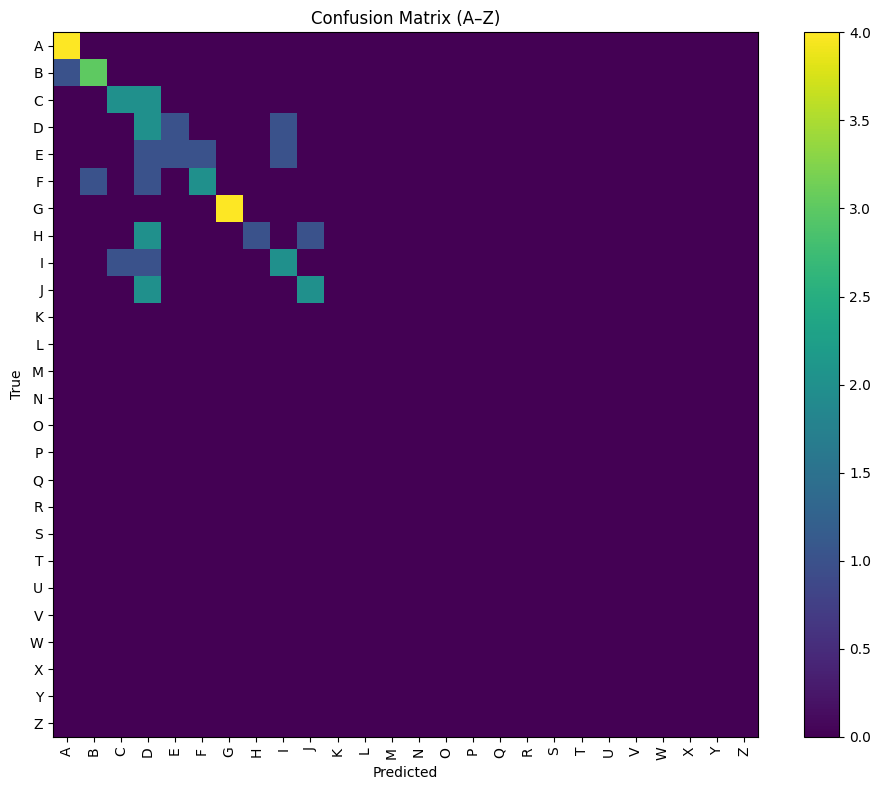

In [95]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (A–Z)")
plt.colorbar()
ticks = np.arange(26)
plt.xticks(ticks, LABELS, rotation=90)
plt.yticks(ticks, LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Wrong predictions: 17 / 40


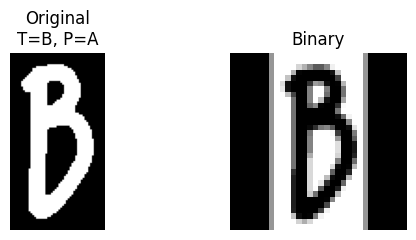

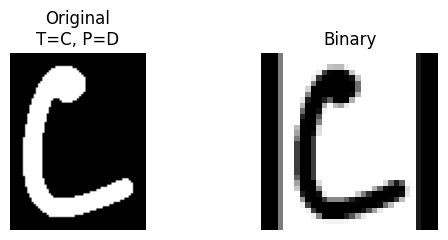

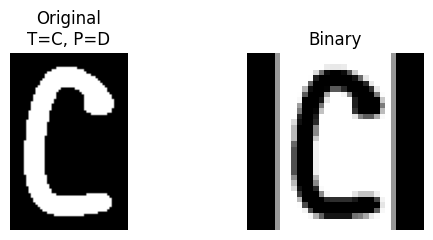

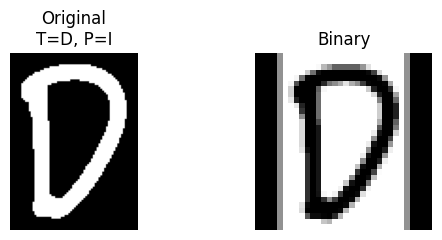

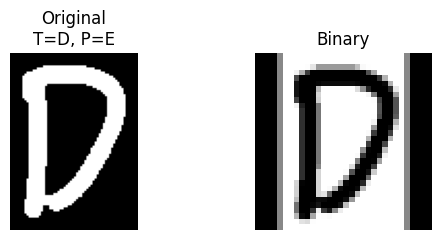

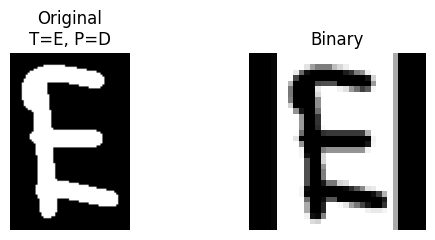

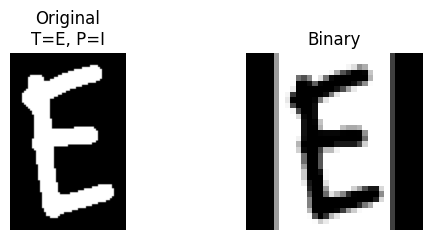

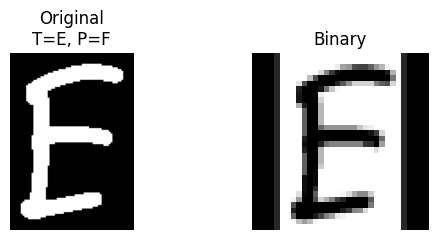

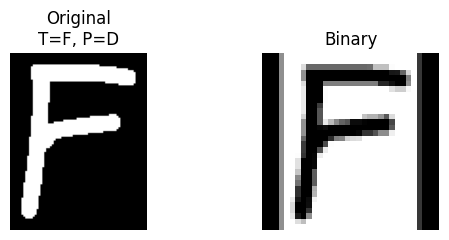

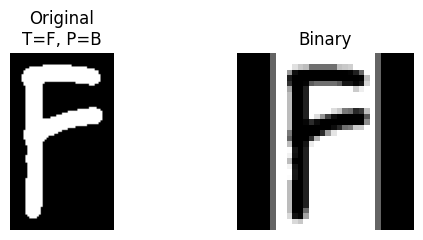

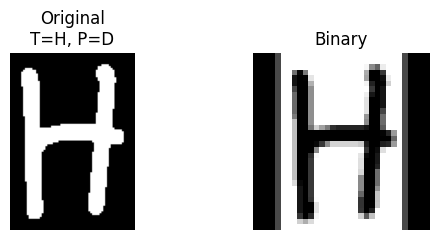

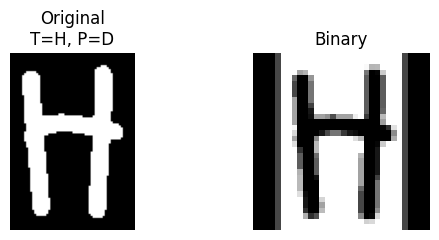

In [96]:
def label_to_char(label_id: int) -> str:
    return chr(label_id + 65)

wrong = np.where(y_test != y_pred)[0]
print("Wrong predictions:", len(wrong), "/", len(y_test))

# show up to 12 wrong examples
show_n = min(12, len(wrong))
for wi in wrong[:show_n]:
    global_index = test_idx[wi]
    img_path = paths[global_index]
    img = cv2.imread(img_path)
    bin_img = preprocess_char(img, out_size=IMG_SIZE)

    true_c = label_to_char(int(y_test[wi]))
    pred_c = label_to_char(int(y_pred[wi]))

    plt.figure(figsize=(6, 2.5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original\nT={true_c}, P={pred_c}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Binary")
    plt.imshow(bin_img, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [97]:
# MODEL_DIR = Path("model_out")
# MODEL_DIR.mkdir(exist_ok=True)

# np.save(MODEL_DIR / "X_train.npy", X_train)
# np.save(MODEL_DIR / "y_train.npy", y_train)

# meta = {
#     "IMG_SIZE": IMG_SIZE,
#     "ZONES": ZONES,
#     "K": K,
#     "TRAIN_SPLIT": TRAIN_SPLIT,
#     "SEED": SEED,
# }
# print("Saved training set to:", MODEL_DIR.resolve())
# print("Meta:", meta)